# Compare photometry in the new and old Stripe82 catalogs 
# to Gaia DR2 photometry and derive corrections for systematics 

[Link to helper tools](#dataTools) 

[Link to data reading](#dataReading) 

[Link to data analysis](#dataAnalysis) 

In [1]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

<a id='dataTools'></a>

### Helper Tools

In [2]:
### selection tools and numerical analysis 

# robust standard deviation
def sigG(arr):
    return 0.741*(np.quantile(arr, 0.75)-np.quantile(arr, 0.25))

def checkNobs(d, band):
    str1 = band + '_Nobs_old'
    arr1 = d[str1]
    print(band, 'band, OLD:')
    printStats(arr1)
    str1 = band + '_Nobs_new'
    arr1 = d[str1]
    print('        NEW:')
    printStats(arr1)
    print('      DIFF:')
    str2 = 'd' + band
    arr2 = d[str2]
    printStats(arr2)
    return
  
def printStats(arr):
    print('           ', np.min(arr), np.mean(arr), np.median(arr), np.max(arr), np.size(arr)) 
    return 

# given vectors x and y, fit medians in bins from xMin to xMax, with Nbin steps,
# and return xBin, medianBin, medianErrBin 
def fitMedians(x, y, xMin, xMax, Nbin, verbose=1): 

    # first generate bins
    xEdge = np.linspace(xMin, xMax, (Nbin+1)) 
    xBin = np.linspace(0, 1, Nbin)
    nPts = 0*np.linspace(0, 1, Nbin)
    medianBin = 0*np.linspace(0, 1, Nbin)
    sigGbin = -1+0*np.linspace(0, 1, Nbin) 
    for i in range(0, Nbin): 
        xBin[i] = 0.5*(xEdge[i]+xEdge[i+1]) 
        yAux = y[(x>xEdge[i])&(x<=xEdge[i+1])]
        if (yAux.size > 0):
            nPts[i] = yAux.size
            medianBin[i] = np.median(yAux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
            sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])
        else:
            nPts[i] = 0
            medianBin[i] = 0
            sigGbin[i] = 0
        
    if (verbose):
        print('median:', np.median(medianBin[nPts>0]), 'std.dev:', np.std(medianBin[nPts>0]))

    return xBin, nPts, medianBin, sigGbin

In [3]:
## for Gaia-related analysis

from scipy import stats
from scipy import optimize

# this function computes polynomial models given some data x
# and parameters theta
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(data, theta, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args)
               for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(data, degree, model=polynomial_fit):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(data, theta, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

 
# this function computes a linear combination of 4 functions
# given parameters theta
def linear_fit(coeffs, x, w, y, z):
    ffit = coeffs[0]*x + coeffs[1]*w + coeffs[2]*y + coeffs[3]*z 
    return ffit

# compute the data log-likelihood given a model
def logL2(dataL, coeffs, model=linear_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, w, y, z, f, sigma_f = dataL
    f_fit = model(coeffs, x, w, y, z)
    return sum(stats.norm.logpdf(*args)
               for args in zip(f, f_fit, sigma_f))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_lintheta(dataL, degree=4, model=linear_fit):
    coeffs_0 = degree * [0]
    neg_logL = lambda coeffs: -logL2(dataL, coeffs, model)
    return optimize.fmin_bfgs(neg_logL, coeffs_0, disp=False)



In [4]:
### plots 

# quick plot 
def qp(d, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax):
    ax = plt.axes()
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.scatter(d[Xstr], d[Ystr], s=0.01, c='blue')  
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return

# quick plot - compare three subsamples
def qp3(d1, d2, d3, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax):
    ax = plt.axes()
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.scatter(d1[Xstr], d1[Ystr], s=0.01, c='green') 
    ax.scatter(d2[Xstr], d2[Ystr], s=0.01, c='red') 
    ax.scatter(d3[Xstr], d3[Ystr], s=0.01, c='blue') 
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return

# quick plot - binned median
def qpBM(d, Xstr, Xmin, Xmax, Ystr, Ymin, Ymax, nBin, Nsigma=3, offset=0.01):
         
    print('medianAll:', np.median(d[Ystr]), 'std.dev.All:', sigG(d[Ystr]))
    print('N=', np.size(d[Ystr]), 'min=', np.min(d[Ystr]), 'max=', np.max(d[Ystr]))

    ax = plt.axes()
    ax.scatter(d[Xstr], d[Ystr], s=0.01, c='black') 
    # binning
    xBinM, nPtsM, medianBinM, sigGbinM = fitMedians(d[Xstr], d[Ystr], Xmin, Xmax, nBin, 1)
    # plotting
    ax.scatter(xBinM, medianBinM, s=30.0, c='black', alpha=0.8)
    ax.scatter(xBinM, medianBinM, s=15.0, c='yellow', alpha=0.3)
    #
    TwoSigP = medianBinM + Nsigma*sigGbinM
    TwoSigM = medianBinM - Nsigma*sigGbinM 
    ax.plot(xBinM, TwoSigP, c='yellow')
    ax.plot(xBinM, TwoSigM, c='yellow')
    #
    rmsBin = np.sqrt(nPtsM) / np.sqrt(np.pi/2) * sigGbinM
    rmsP = medianBinM + rmsBin
    rmsM = medianBinM - rmsBin
    ax.plot(xBinM, rmsP, c='cyan')
    ax.plot(xBinM, rmsM, c='cyan')
    # 
    xL = np.linspace(-100,100)
    ax.plot(xL, 0*xL, c='red')
    ax.plot(xL, 0*xL+offset, '--', c='red')
    ax.plot(xL, 0*xL-offset, '--', c='red')
    # 
    ax.set_xlabel(Xstr)
    ax.set_ylabel(Ystr)
    ax.set_xlim(Xmin, Xmax)
    ax.set_ylim(Ymin, Ymax)
    plt.show()
    return
 
def qphist(arr, xMin, xMax, xLabel, verbose = False):
    ax = plt.axes()
    hist(arr, bins='knuth', ax=ax, histtype='stepfilled', ec='k', fc='#AAAAAA')
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    plt.show()
    if (verbose):
        print('Min, max: ', np.min(arr),np.max(arr)) 
        print('Mean, median: ', np.mean(arr),np.median(arr)) 
        print('sigG, st.dev.: ', sigG(arr),np.std(arr)) 
    return 

def qpH0(arr, xMin, xMax, xLabel, nBins=0, verbose = False):
    ax = plt.axes()
    if (nBins>0):
        hist, bins = np.histogram(arr, bins=nBins)
        center = (bins[:-1]+bins[1:])/2
        ax.plot(center, hist, drawstyle='steps', c='blue')   
    else:
        plt.hist(arr, bins='auto', histtype='stepfilled', ec='k', fc='red') 
 
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    ax.plot([-1000, 1000], [0, 0], '--k')
    plt.show()
    if (verbose):
        print('Min, max: ', np.min(arr),np.max(arr)) 
        print('Mean, median: ', np.mean(arr),np.median(arr)) 
        print('sigG, st.dev.: ', sigG(arr),np.std(arr))  
    return 

def qpHdm(d, band, dmMax, xMin, xMax, nBins=50, verbose=False):
    str = 'd' + band
    dm = 1000*d[str]
    dmOK = dm[np.abs(dm)<(1000*dmMax)]
    xLabel = str + ' (milimag)'
    qpH0(dmOK, 1000*xMin, 1000*xMax, xLabel, nBins, verbose)
    return np.mean(dmOK), np.median(dmOK), sigG(dmOK)


def qp2hist(arr1, arr2, xMin, xMax, xLabel, nBins=0, verbose = False):
    ax = plt.axes()
    if (nBins>0):
        hist, bins = np.histogram(arr1, bins=nBins)
        center = (bins[:-1]+bins[1:])/2
        ax.plot(center, hist, drawstyle='steps', c='red')   
        hist2, bins2 = np.histogram(arr2, bins=nBins)
        center2 = (bins2[:-1]+bins2[1:])/2
        ax.plot(center2, hist2, drawstyle='steps', c='blue')   
    else:
        plt.hist(arr1, bins='auto', histtype='stepfilled', ec='k', fc='yellow')
        plt.hist(arr2, bins='auto', histtype='stepfilled', ec='red', fc='blue')
 
    ax.set_xlabel(xLabel)
    ax.set_ylabel('n')
    ax.set_xlim(xMin, xMax)
    plt.show()
    if (verbose):
        print('Min: ', np.min(arr1),np.min(arr2)) 
        print('Median: ', np.median(arr1),np.median(arr2)) 
        print('sigG: ', sigG(arr1),sigG(arr2)) 
        print('Max: ', np.max(arr1),np.max(arr2)) 
    return 

<a id='dataReading'></a>

### Define paths and catalogs 

In [113]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/Data"
# the original SDSS catalog from 2007
sdssOldCat = ZIdataDir + "/" + "stripe82calibStars_v2.6.dat"
# Karun's new catalog from 2020
sdssNewCat = ZIdataDir + "/" + "N2020_stripe82calibStars.dat" 
readFormat = 'csv'
sdssNewCatRecalib = ZIdataDir + "/" + "stripe82calibStars_v3.1.dat" 
if (1):
    # for testing new recalibrated catalog
    sdssNewCat = sdssNewCatRecalib
    readFormat = 'ascii'

# Gaia DR2 
GaiaDR2Cat = ZIdataDir + "/" + "Stripe82_GaiaDR2.dat"

In [6]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

In [7]:
%%time
# old
sdssOld = Table.read(sdssOldCat, format='ascii', names=colnamesSDSS) 
np.size(sdssOld)

CPU times: user 22.9 s, sys: 4.98 s, total: 27.8 s
Wall time: 28.8 s


1006849

In [114]:
%%time
# new 
sdssNew = Table.read(sdssNewCat, format=readFormat, names=colnamesSDSS)
np.size(sdssNew)

CPU times: user 22.8 s, sys: 4.62 s, total: 27.4 s
Wall time: 26.8 s


991472

#### Simple positional match using ra/dec

In [115]:
sdssOld_coords = SkyCoord(ra = sdssOld['ra']*u.degree, dec= sdssOld['dec']*u.degree) 
sdssNew_coords = SkyCoord(ra = sdssNew['ra']*u.degree, dec= sdssNew['dec']*u.degree) 
# this is matching sdssNew to sdssOld, so that indices are into sdssNew catalog
# makes sense in this case since the sdssOld catalog is (a little bit) bigger 
# than sdssNew (1006849 vs 1005470)
idx, d2d, d3d = sdssNew_coords.match_to_catalog_sky(sdssOld_coords)  

In [116]:
# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
new_old = hstack([sdssNew, sdssOld[idx]], table_names = ['new', 'old'])
new_old['sep_2d_arcsec'] = d2d.arcsec
# good matches between the old and new catalogs
MAX_DISTANCE_ARCSEC = 0.5
sdss = new_old[(new_old['sep_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
print(np.size(sdss))

991472


In [120]:
print(np.max(sdss['r_mErr_new']), np.median(sdss['r_mErr_new']))

0.05 0.006


### apply standard cuts as in old catalog:


In [121]:
def selectCatalog(sdssIn, sdssOut): 
    print('starting with', len(sdssIn))
    a1 = sdssIn['g_Nobs_new']
    a2 = sdssIn['r_Nobs_new']
    a3 = sdssIn['i_Nobs_new']
    mOK = sdssIn[(a1>3)&(a2>3)&(a3>3)]
    print('after Nobs cuts:', len(mOK))
    # chi2<3 cut:
    a1 = mOK['g_chi2_new']
    a2 = mOK['r_chi2_new']
    a3 = mOK['i_chi2_new']
    mOK2 = mOK[(a1<3)&(a2<3)&(a3<3)]
    print('after chi2 cuts:', len(mOK2))
    # and the final standard error of the mean r band mag: <0.05 mag
    sdssOut = mOK2[mOK2['r_mErr_new']<=0.05]
    print('after r_mErr cut:', len(sdssOut))
    return sdssOut

In [122]:
mOK3 = selectCatalog(sdss, mOK3)

starting with 991472
after Nobs cuts: 991472
after chi2 cuts: 991472
after r_mErr cut: 991472


In [18]:
print(996147/1006849)
print(993774/1006849)
print(991472/1006849)

0.989370799394944
0.9870139415145668
0.9847276006630588


### now match to Gaia DR2...

In [123]:
colnamesGaia = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
if (1):
    gaia = Table.read(GaiaDR2Cat, format='ascii', names=colnamesGaia)
else: 
    gaia = Table.read(GaiaDR2Cat1perc, format='ascii', names=colnamesGaia)
gaia['raG'] = gaia['ra']
gaia['decG'] = gaia['dec']

In [124]:
sdss_coords = SkyCoord(ra = sdss['ra_old']*u.degree, dec= sdss['dec_old']*u.degree) 
gaia_coords = SkyCoord(ra = gaia['raG']*u.degree, dec= gaia['decG']*u.degree) 

# this is matching gaia to sdss, so that indices are into sdss catalog
# makes sense in this case since the sdss catalog is bigger than gaia
idxG, d2dG, d3dG = gaia_coords.match_to_catalog_sky(sdss_coords)  

# object separation is an object with units, 
# I add that as a column so that one can 
# select based on separation to the nearest matching object
gaia_sdss = hstack([gaia, sdss[idxG]], table_names = ['gaia', 'sdss'])
gaia_sdss['sepSG_2d_arcsec'] = d2dG.arcsec

In [125]:
### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumns(matches):
    matches['dra'] = (matches['ra_new']-matches['ra_old'])*3600
    matches['ddec'] = (matches['dec_new']-matches['dec_old'])*3600
    matches['ra'] = matches['ra_old']
    ra = matches['ra'] 
    matches['raW'] = np.where(ra > 180, ra-360, ra) 
    matches['dec'] = matches['dec_old']
    matches['u'] = matches['u_mMed_old']
    matches['g'] = matches['g_mMed_old']
    matches['r'] = matches['r_mMed_old']
    matches['i'] = matches['i_mMed_old']
    matches['z'] = matches['z_mMed_old']
    matches['ug'] = matches['u_mMed_old'] - matches['g_mMed_old']
    matches['gr'] = matches['g_mMed_old'] - matches['r_mMed_old']
    matches['ri'] = matches['r_mMed_old'] - matches['i_mMed_old']
    matches['gi'] = matches['g_mMed_old'] - matches['i_mMed_old']
    matches['du'] = matches['u_mMed_old'] - matches['u_mMed_new']
    matches['dg'] = matches['g_mMed_old'] - matches['g_mMed_new']
    matches['dr'] = matches['r_mMed_old'] - matches['r_mMed_new']
    matches['di'] = matches['i_mMed_old'] - matches['i_mMed_new']
    matches['dz'] = matches['z_mMed_old'] - matches['z_mMed_new']
    # Gaia 
    matches['draGold'] = -3600*(matches['ra_old'] - matches['raG']) 
    matches['draGnew'] = -3600*(matches['ra_new'] - matches['raG']) 
    matches['ddecGold'] = -3600*(matches['dec_old'] - matches['decG']) 
    matches['ddecGnew'] = -3600*(matches['dec_new'] - matches['decG']) 
    # photometric
    matches['gGr_old'] = matches['Gmag'] - matches['r_mMed_old']
    matches['gGr_new'] = matches['Gmag'] - matches['r_mMed_new']
    return

In [126]:
derivedColumns(gaia_sdss) 

### Select good matches and compare both catalogs to Gaia DR2

In [127]:
## first limit astrometric distance and 
## require at least 4 epochs as in the old catalog
MAX_DISTANCE_ARCSEC = 0.5
m1 = gaia_sdss[(gaia_sdss['sepSG_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
a1 = m1['g_Nobs_new']
a2 = m1['r_Nobs_new']
a3 = m1['i_Nobs_new']
mOK = m1[(a1>3)&(a2>3)&(a3>3)]
print(len(new_old))
print(len(m1))
print(len(mOK))

991472
885408
885408


In [128]:
# doGaiaAll(mOK)
def doGaiaAll(d, Cstr):
    # Cstr = 'gGr_old' or 'gGr_new'  
    gi = d['gi']
    Gr = d[Cstr]
    Gmag = d['Gmag']
    xBin, nPts, medianBin, sigGbin = fitMedians(gi, Gr, -0.7, 4.0, 47, 0)
    data = np.array([xBin, medianBin, sigGbin])
    Ndata = xBin.size
    # get best-fit parameters  
    thetaCloc = best_theta(data,7)
    # generate best fit lines on a fine grid 
    xfit = np.linspace(-1.1, 4.3, 1000)
    yfit = polynomial_fit(thetaCloc, xfit) 

    d['gGrFit'] = polynomial_fit(thetaCloc, gi)
    d['dgGr'] = d[Cstr] - d['gGrFit']  
    Dc = d[(d['gi']>0.4)&(d['gi']<3.0)]
    
    DcB = Dc[(Dc['Gmag']>14.5)&(Dc['Gmag']<20.0)]
    DcB['GrResid'] = DcB['dgGr'] - np.median(DcB['dgGr'])
    DcBok = DcB[np.abs(DcB['dgGr'])<0.1]
    
    qpBM(DcBok, 'dec', -1.3, 1.3, 'GrResid', -0.03, 0.03, 260) 
    qpBM(DcBok, 'raW', -51.5, 60, 'GrResid', -0.03, 0.03, 112) 
    
    return thetaCloc, DcBok
 

medianAll: 4.78898725619209e-06 std.dev.All: 0.017051214434739864
N= 520116 min= -0.09553124802525215 max= 0.1044523856971118
median: -9.797563320441266e-06 std.dev: 0.000540156028790298


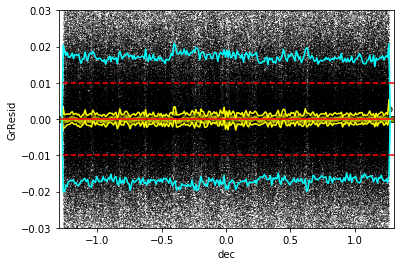

medianAll: 4.78898725619209e-06 std.dev.All: 0.017051214434739864
N= 520116 min= -0.09553124802525215 max= 0.1044523856971118
median: 0.00018666774887485596 std.dev: 0.0007101265234944989


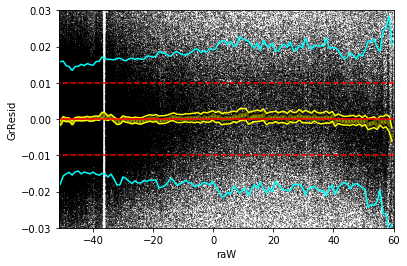

In [129]:
thetaC, mOKcBok = doGaiaAll(mOK, 'gGr_new')

In [130]:
## use 7-th degree polynomial and 0.4 < g-i < 3.0 for recalibration
mOK['gGrFit'] = polynomial_fit(thetaC, mOK['gi'])
mOK['dgGr'] = mOK['gGr_new'] - mOK['gGrFit']
mOKc = mOK[(mOK['gi']>0.4)&(mOK['gi']<3.0)]

In [131]:
## for zero point calibration, take 14.5 < G < 20.0 
mOKcB = mOKc[(mOKc['Gmag']>14.5)&(mOKc['Gmag']<20.0)]
mOKcB['GrResid'] = mOKcB['dgGr'] - np.median(mOKcB['dgGr'])
mOKcBok = mOKcB[np.abs(mOKcB['dgGr'])<0.1]
print(np.size(mOKcB), np.size(mOKcBok))

536411 520116


In [132]:
sigG(mOKcBok['GrResid'])

0.017051214434739864

medianAll: 4.78898725619209e-06 std.dev.All: 0.017051214434739864
N= 520116 min= -0.09553124802525215 max= 0.1044523856971118
median: -9.797563320441266e-06 std.dev: 0.000540156028790298


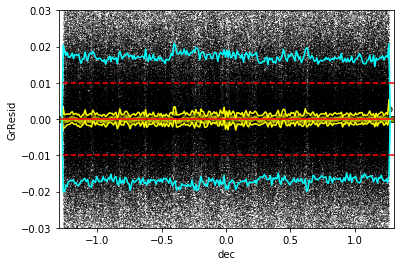

In [133]:
qpBM(mOKcBok, 'dec', -1.3, 1.3, 'GrResid', -0.03, 0.03, 260) 

medianAll: 4.78898725619209e-06 std.dev.All: 0.017051214434739864
N= 520116 min= -0.09553124802525215 max= 0.1044523856971118
median: 0.00018666774887485596 std.dev: 0.0007101265234944989


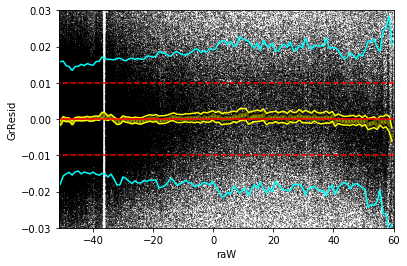

In [134]:
qpBM(mOKcBok, 'raW', -51.5, 60, 'GrResid', -0.03, 0.03, 112) 

#### Recalibrate R.A. residuals


In [31]:
RAbin, RAnPts, RAmedianBin, RAsigGbin = fitMedians(mOKcBok['raW'], mOKcBok['GrResid'], -51.5, 60.0, 112, 1)

median: -0.00048414068535303223 std.dev: 0.0034513719587765854


#### Recalibrate Dec residuals

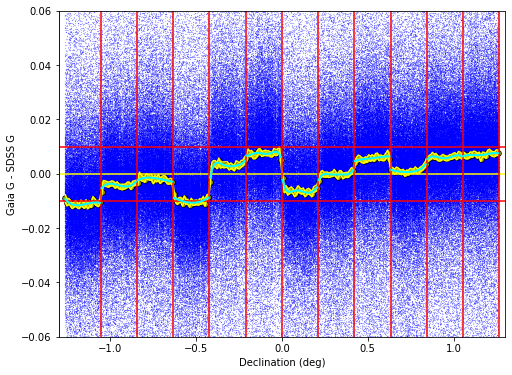

In [32]:
decOK = mOKcBok['dec_new']
GrResid =  mOKcBok['GrResid']
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decOK, GrResid, s=0.01, c='blue')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.06,0.06)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Gaia G - SDSS G')
xBin, nPts, medianBin, sigGbin = fitMedians(decOK, GrResid, -1.266, 1.264, 252, 0)
ax.scatter(xBin, medianBin, s=30.0, c='black', alpha=0.9)
ax.scatter(xBin, medianBin, s=15.0, c='yellow', alpha=0.5)
TwoSigP = medianBin + 2*sigGbin
TwoSigM = medianBin - 2*sigGbin 
ax.plot(xBin, TwoSigP, c='yellow')
ax.plot(xBin, TwoSigM, c='yellow')
xL = np.linspace(-100,100)
ax.plot(xL, 0*xL+0.00, c='yellow')
ax.plot(xL, 0*xL+0.01, c='red')
ax.plot(xL, 0*xL-0.01, c='red')
dCleft = -1.3
ax.plot(0*xL+dCleft, xL, c='red')
alltheta = []
for i in range(0,12):
    decCol = -1.2655 + (i+1)*0.2109
    ax.plot(0*xL+decCol, xL, c='red')
    xR = xBin[(xBin>dCleft)&(xBin<decCol)]
    yR = medianBin[(xBin>dCleft)&(xBin<decCol)]
    dyR = sigGbin[(xBin>dCleft)&(xBin<decCol)]
    data = np.array([xR, yR, dyR])
    theta2 = best_theta(data,5)
    alltheta.append(theta2)
    yfit = polynomial_fit(theta2, xR)
    ax.plot(xR, yfit, c='cyan', lw=2)
    dCleft = decCol
    rrr = yR - yfit
    # print(i, np.median(rrr), np.std(rrr))  # 2 milimag scatter 
    # print(i, theta2)

In [33]:
# let's now correct all mags with this correction
thetaRecalib = alltheta

In [34]:
decLeft = -1.3
for i in range(0,12):
    decRight = -1.2655 + (i+1)*0.2109
    decArr = np.linspace(decLeft, decRight, 100)
    thetaBin = thetaRecalib[i] 
    ZPfit = polynomial_fit(thetaBin, decArr)
    if (i==0):
        decCorrGrid = decArr
        ZPcorr = ZPfit
    else: 
        decCorrGrid = np.concatenate([decCorrGrid, decArr]) 
        ZPcorr = np.concatenate([ZPcorr, ZPfit])
    decLeft = decRight

In [35]:
mOKtest = mOK[mOK['r_Nobs_new']>3]

In [36]:
# Dec correction
decGrid2correct = mOKtest['dec_new']
ZPcorrectionsDec = np.interp(decGrid2correct, decCorrGrid, ZPcorr)
# RA correction 
raWGrid2correct = mOKtest['raW'] 
ZPcorrectionsRA = np.interp(raWGrid2correct, RAbin, RAmedianBin)
print(np.std(ZPcorrectionsDec), np.std(ZPcorrectionsRA))

0.006257989581284236 0.0030115405916095344


Text(0, 0.5, 'Correction')

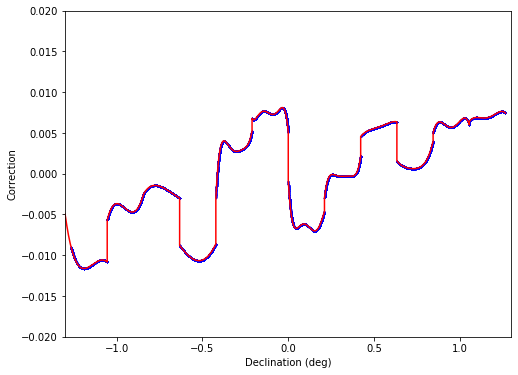

In [37]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(decGrid2correct, ZPcorrectionsDec, s=0.01, c='blue')
ax.plot(decCorrGrid, ZPcorr, c='red')
ax.set_xlim(-1.3,1.3)
ax.set_ylim(-0.02,0.02)
ax.set_xlabel('Declination (deg)')
ax.set_ylabel('Correction')

-0.02686710958917645

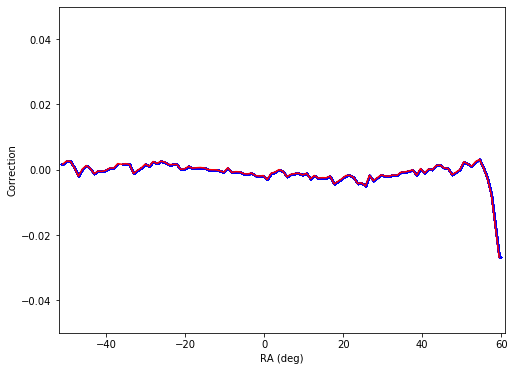

In [38]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(raWGrid2correct, ZPcorrectionsRA, s=0.01, c='blue')
ax.plot(RAbin, RAmedianBin, c='red')
ax.set_xlim(-52,61)
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Correction') 
np.min(ZPcorrectionsRA)

In [39]:
mOKtest['ZPcorrectionsRA'] = ZPcorrectionsRA
mOKtest['ZPcorrectionsDec'] = ZPcorrectionsDec
mOKtest['r_mMed_new'] = mOKtest['r_mMed_new'] + mOKtest['ZPcorrectionsRA'] + mOKtest['ZPcorrectionsDec']
mOKtest['gGr_new'] = mOKtest['Gmag'] - mOKtest['r_mMed_new']
mOKtest['gGrFit'] = polynomial_fit(thetaC, mOKtest['gi'])
mOKtest['dgGr'] = mOKtest['gGr_new'] - mOKtest['gGrFit']

medianAll: -2.4814392342142888e-05 std.dev.All: 0.017064750806751915
N= 521260 min= -0.09556561258070115 max= 0.10442430909084191
median: -4.31541865355458e-05 std.dev: 0.0005352289357129273


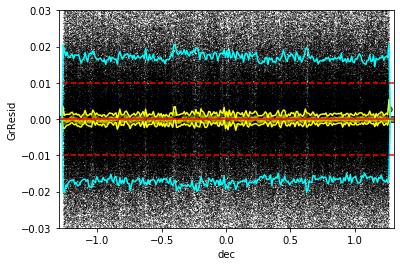

medianAll: -2.4814392342142888e-05 std.dev.All: 0.017064750806751915
N= 521260 min= -0.09556561258070115 max= 0.10442430909084191
median: 0.00016531253604895428 std.dev: 0.0007131774834238425


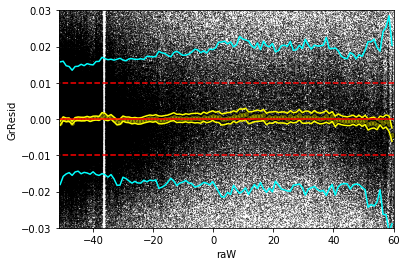

In [40]:
thetaCtest, DcBokTest_new = doGaiaAll(mOKtest, 'gGr_new')

## Now save correction arrays, then apply to original file, and then test

In [41]:
#np.savetxt('ZPcorrectionsRA_v3.1.dat', (RAbin, RAmedianBin)) 
#np.savetxt('ZPcorrectionsDec_v3.1.dat', (decCorrGrid, ZPcorr))

In [42]:
# read back 
zpRAgrid, zpRA = np.loadtxt('ZPcorrectionsRA_v3.1.dat')  
zpDecgrid, zpDec = np.loadtxt('ZPcorrectionsDec_v3.1.dat')  

In [43]:
mOKtest = mOK[mOK['r_Nobs_new']>3]

In [44]:
# Dec correction
decGrid2correct = mOKtest['dec_new']
ZPcorrectionsDec = np.interp(decGrid2correct, zpDecgrid, zpDec)
# RA correction 
raWGrid2correct = mOKtest['raW'] 
ZPcorrectionsRA = np.interp(raWGrid2correct, zpRAgrid, zpRA)
print(np.std(ZPcorrectionsDec), np.std(ZPcorrectionsRA))

0.006257989581284236 0.0030115405916095344


In [45]:
mOKtest['ZPcorrectionsRA'] = ZPcorrectionsRA
mOKtest['ZPcorrectionsDec'] = ZPcorrectionsDec
mOKtest['r_mMed_new'] = mOKtest['r_mMed_new'] + mOKtest['ZPcorrectionsRA'] + mOKtest['ZPcorrectionsDec']
mOKtest['gGr_new'] = mOKtest['Gmag'] - mOKtest['r_mMed_new']
mOKtest['gGrFit'] = polynomial_fit(thetaC, mOKtest['gi'])
mOKtest['dgGr'] = mOKtest['gGr_new'] - mOKtest['gGrFit']

medianAll: -2.4814392342142888e-05 std.dev.All: 0.017064750806751915
N= 521260 min= -0.09556561258070115 max= 0.10442430909084191
median: -4.31541865355458e-05 std.dev: 0.0005352289357129273


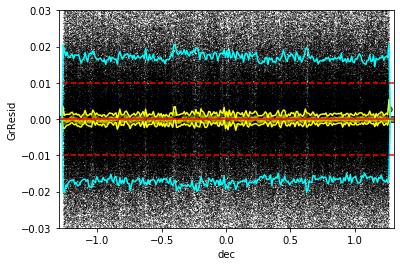

medianAll: -2.4814392342142888e-05 std.dev.All: 0.017064750806751915
N= 521260 min= -0.09556561258070115 max= 0.10442430909084191
median: 0.00016531253604895428 std.dev: 0.0007131774834238425


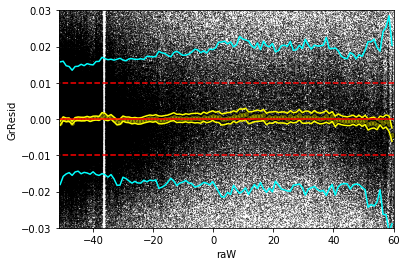

In [46]:
thetaCtest, DcBokTest_new = doGaiaAll(mOKtest, 'gGr_new')

In [52]:
# gray zero point recalibration files 
zpRAgrid, zpRA = np.loadtxt('ZPcorrectionsRA_v3.1.dat')  
zpDecgrid, zpDec = np.loadtxt('ZPcorrectionsDec_v3.1.dat')  
# Dec correction
decGrid2correct = sdssRecalib['dec']
ZPcorrectionsDec = np.interp(decGrid2correct, zpDecgrid, zpDec)
# RA correction 
ra = sdssRecalib['ra'] 
raWGrid2correct = np.where(ra > 180, ra-360, ra) 
ZPcorrectionsRA = np.interp(raWGrid2correct, zpRAgrid, zpRA)
print(np.std(ZPcorrectionsDec), np.std(ZPcorrectionsRA))

0.0062493071607384884 0.002953464554960985


In [77]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/Data"
# Karun's new catalog from 2020
sdssNewCat = ZIdataDir + "/" + "N2020_stripe82calibStars.dat" 
readFormat = 'csv'
sdssNew = Table.read(sdssNewCat, format=readFormat, names=colnamesSDSS) 

In [102]:
sdssOld_coords = SkyCoord(ra = sdssOld['ra']*u.degree, dec= sdssOld['dec']*u.degree) 
sdssNew_coords = SkyCoord(ra = sdssNew['ra']*u.degree, dec= sdssNew['dec']*u.degree) 
idx, d2d, d3d = sdssNew_coords.match_to_catalog_sky(sdssOld_coords)  
# good matches between the old and new catalogs
MAX_DISTANCE_ARCSEC = 0.5
sdssNewOK = sdssNew[d2d.arcsec < MAX_DISTANCE_ARCSEC]

In [89]:
def selectCatalogNew(sdssIn): 
    print('starting with', len(sdssIn))
    a1 = sdssIn['g_Nobs']
    a2 = sdssIn['r_Nobs']
    a3 = sdssIn['i_Nobs']
    mOK = sdssIn[(a1>3)&(a2>3)&(a3>3)]
    print('after Nobs cuts:', len(mOK))
    # chi2<3 cut:
    a1 = mOK['g_chi2']
    a2 = mOK['r_chi2']
    a3 = mOK['i_chi2']
    mOK2 = mOK[(a1<3)&(a2<3)&(a3<3)]
    print('after chi2 cuts:', len(mOK2))
    # and the final standard error of the mean r band mag: <0.05 mag
    sdssOut = mOK2[mOK2['r_mErr']<0.05]
    print('after r_mErr cut:', len(sdssOut))
    return sdssOut

In [103]:
sdssOut = selectCatalogNew(sdssNewOK) 

starting with 1000140
after Nobs cuts: 996147
after chi2 cuts: 993774
after r_mErr cut: 991472


In [104]:
sdssOut.sort('calib_fla') 

In [105]:
# gray zero point recalibration files 
zpRAgrid, zpRA = np.loadtxt('ZPcorrectionsRA_v3.1.dat')  
zpDecgrid, zpDec = np.loadtxt('ZPcorrectionsDec_v3.1.dat')  
# Dec correction
decGrid2correct = sdssOut['dec']
ZPcorrectionsDec = np.interp(decGrid2correct, zpDecgrid, zpDec)
# RA correction 
ra = sdssOut['ra'] 
raWGrid2correct = np.where(ra > 180, ra-360, ra) 
ZPcorrectionsRA = np.interp(raWGrid2correct, zpRAgrid, zpRA)
print(np.std(ZPcorrectionsDec), np.std(ZPcorrectionsRA))
for b in ('u', 'g', 'r', 'i', 'z'):
    for mtype in ('_mMed', '_mMean'):
        mstr = b + mtype
        sdssOut[mstr] = sdssOut[mstr] + ZPcorrectionsRA + ZPcorrectionsDec 

0.0062488750280265465 0.0029590709599609092


In [111]:
def getSSCentry(df, i):
    entry = {}
    ra = df['ra'][i]
    dec = df['dec'][i] 
    raRMS = df['raRMS'][i] 
    decRMS = df['raRMS'][i] 
    nEpochs = df['nEpochs'][i]  
    AR_val = df['AR_val'][i]  
    entry['coord'] = (ra, dec, raRMS, decRMS, nEpochs, AR_val)
    for b in ('u','g','r','i','z'):
        lst = []
        for q in ('Nobs', 'mMed', 'mMean', 'mErr', 'rms_scatt', 'chi2'): 
            qb = b + '_' + q
            lst.append(df[qb][i])
        entry[b] = lst
    return entry

def SSCentryToOutFileRow(entry, SSCindex, OutFile):
    OutFile.write('%s' % SSCindex)
    format = '%12.6f %10.6f %.4f %.4f %3d %7.3f'
    OutFile.write(format % (entry['coord']))
    format = '%3d %.3f %.3f %.3f %.3f %.3f '
    for i in ('u', 'g', 'r', 'i', 'z'):
        sss = (entry[i][0], entry[i][1], entry[i][2], entry[i][3], entry[i][4], entry[i][5])
        OutFile.write(format % sss)
    OutFile.write('\n')
    return 

In [112]:
SSCindexRoot = 'CALIBSTARS_'
# outFile = ZIdataDir + "/" + "stripe82calibStars_v3.1.dat"
newSSC = open(outFile,'w')
df = sdssOut
Ngood = 0
for i in range(0, np.size(df)):
    Ngood += 1
    NoldCat = df['calib_fla'][i]
    strNo = f'{Ngood:07}'
    SSCindex = SSCindexRoot + strNo 
    SSCrow = getSSCentry(df, i)
    SSCentryToOutFileRow(SSCrow, SSCindex, newSSC) 
newSSC.close()
print(Ngood, 'rows in file', outFile)

991472 rows in file /Users/ivezic/Work/Science/CalibrationV2/Data/stripe82calibStars_v3.1.dat
